# Simulation Analysis after running CPPTRAJ

## Import necessary python modules

In [25]:
# Import all necessary python modules for notebook - including handling data, plots and statistics
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.stats import ttest_rel

## MMPBSA Analysis

### Collect Data

In [ ]:
#### Function to load and process data with normalisation ####
# Read in filename, name of data, reference column for normalisation and if the data is the experimental
# Default values for reference column and is_exp set as None and False
def load_and_process_data(filename, dataname, reference_col=None, is_exp=False):
    # Read data, with 'run' as index for the computational data (experimental does not have run column)
    data = pd.read_csv(filename, index_col=0) if not is_exp else pd.read_csv(filename)

    # Experimental data is already normalized and does not require further processing, data returned as it is
    if is_exp:
        return data
    
    # Select only numeric columns for averaging
    numeric_data = data.select_dtypes(include=[float, int])  
    # Calculate averages across each column (protein)
    averages = numeric_data.mean(axis=0)
    # Calculate standard deviation for each column (protein)
    std_dev = numeric_data.std(axis=0)
    # Normalise data based on the reference column
    relative_averages = averages - averages[reference_col]
    
    # Return normalised data and standard deviations
    return pd.DataFrame({
            'protein': averages.index,
            dataname: relative_averages.values,
            f'{dataname}_std': std_dev.values
        })
    
#### Function to merge each data frame together ####
# Read in the computational and experimental dataframes
def merge_data_frames(df1, df2, dfexp):
    # Merge the computational dataframes on 'protein'
    merged = pd.merge(df1, df2, on='protein', how='outer')
    # Merge with experimentla dataframe
    merged = pd.merge(merged, dfexp, on='protein', how='outer')
    
    # Return merged dataframe 
    return merged

#### Define file name and data name for each computational data set and for the experimental data ####
# Sample data: HMR and Standard
name1 = 'HMR'
file_data1 = f"{name1}_MMPBSA.csv"
name2 = 'Standard'
file_data2 = f"{name2}_MMPBSA.csv"
name_exp = 'EXP'
file_exp = f"{name_exp}_data.csv"
combined_data_file = 'MMPBSA_avg'

#### Read in and process data ####
# Sample data: data1 = HMR, data2 = Standard, normalised to wildtype ('W')
data1 = load_and_process_data(file_data1, name1, reference_col='W')
data2 = load_and_process_data(file_data2, name2, reference_col='W')

# Read EXP data (no normalisation or averaging needed)
data_exp = load_and_process_data(file_exp, name_exp, is_exp=True)

#### Merge all data into one dataframe ####
final_df = merge_data_frames(data1, data2, data_exp)

#### Save the merged dataframe to a new CSV file ####
final_df.to_csv(f"{combined_data_file}.csv", index=False)

#### Print message indicating new saved csv file ####
print(f"Relative averages and EXP values have been saved to MMPBSA_avg.csv")

Relative averages and EXP values have been saved to MMPBSA_avg.csv


### Plot MMPBSA Data with Linear Regression

Using data file: MMPBSA_avg for HMR and Standard


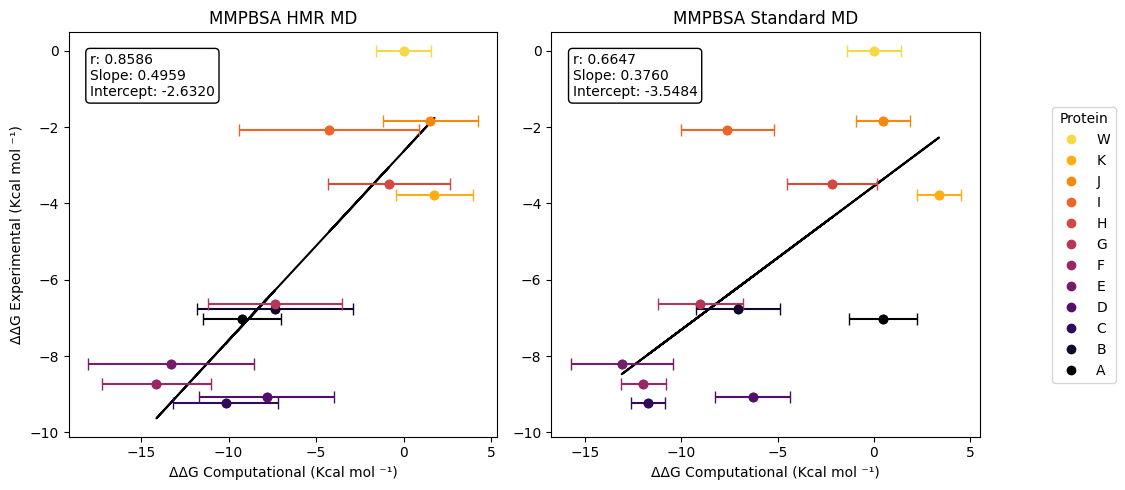

In [62]:
#### Initialise linear regression model ####
regr = linear_model.LinearRegression()

#### Function to load in the combined dataframe ####
def load_data(data_file):
    # Set index of dataframe as 'protein'
    data = pd.read_csv(f"{data_file}.csv", header=0, sep=",").set_index("protein")
    
    # Return dataframe
    return data

#### Function to define a colour map for a certain number of points ####
def define_colormap(num_points):
    # Assign predefined colour map 'inferno' to palet
    palet = plt.cm.inferno
    # Take 90% of colour map to avoid light yellow part that does not appear well on plot
        # Generates 256 evenly spaced values between 0 and 0.9 to subset the colour map
    truncated_palet = LinearSegmentedColormap.from_list(
        'truncated_palet', palet(np.linspace(0, 0.9, 256))
    )
    # Return colours evenly spaced in truncated_palet corresponding to the number of points
    return truncated_palet(np.linspace(0, 1, num_points))

#### Function to plot computational vs experimental data, with linear regression ####
# Read in the axes number, data, data name, colours and plot title
def plot_data(ax, data, dataname, colors, title):
    
    # Define x and y data as computational and experimental data
    x = np.array(data[dataname]).reshape(-1, 1) 
    y = np.array(data["EXP"]).reshape(-1, 1)
    
    # Fit linear regression to the x and y data
    regr.fit(x, y)
    # Plot regression line
    ax.plot(x, regr.coef_ * x + regr.intercept_, color="black")

    # Scatter plot of data with error bars of standard deviation, assigning specifical colour to each protein
    for i, (comp, exp, std, color) in enumerate(zip(data[dataname], data["EXP"], data[f"{dataname}_std"], colors)):
        ax.scatter(comp, exp, color=color)
        ax.errorbar(comp, exp, xerr=std, fmt='o', color=color, capsize=4)

    # Calculate Pearson's r ('_' used as placeholder for p-value which is not used here)
    pearson_r, _ = pearsonr(data[dataname], data["EXP"])
    # 
    ax.text(
        # Coordinates to position text box at top left of plot
        0.05, 0.95, 
        # Print Pearson's r value, slope and intercept of regression line
        f"r: {pearson_r:.4f}\nSlope: {regr.coef_[0][0]:.4f}\nIntercept: {regr.intercept_[0]:.4f}", 
        # Use coordinates as relative to figure (0.05 = 5% from left, 0.95 = 95% from bottom), define font and exact position
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        # Create box around text for easier visualisation
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )
    # Display title of plot
    ax.set_title(title)
    # Display x-axis of plot
    ax.set_xlabel("\u0394\u0394G Computational (Kcal mol \u207B\u00B9)")

#### Set up plot to contain two subplots that share the same y-axis dimensions ####
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

#### Retreive combined data file name and computational data names from previous notebook cell ####
# Try block used to raise error if notebook is run out of order
try:
    # Assuming 'combined_data_file', 'name1', and 'name2' are defined in previous notebook cell:
    combined_data_file, name1, name2
    # Print message to show data has been retrieved
    print(f"Using data file: {combined_data_file} for {name1} and {name2}")

# Raise error suggesting notebook should be run in order
except NameError as e:
    print(f"Error: One or more variables are not defined. Try running the whole notebook in order. Details: {e}")
    raise

#### Load the combined dataframe ####
data = load_data(combined_data_file)

#### Define colors for plotting using number of data points in loaded data ####
colors = define_colormap(len(data.index))

#### Plot datasets ####
# Sample data: HMR, plotted on 1st subplot
plot_data(ax[0], data, name1, colors, "MMPBSA HMR MD")
# Sample data: Standard, plotted on 2nd subplot
plot_data(ax[1], data, name2, colors, "MMPBSA Standard MD")

# Display y-axis for 1st subplot
ax[0].set_ylabel("\u0394\u0394G Experimental (Kcal mol \u207B\u00B9)")
# Display y-axis ticks for 2nd subplot for easier visualisation
ax[1].tick_params(axis='y', which='both', labelleft=True)

#### Add legend ####
# Create 'fake' line to be used to create legend, with colors matching previous plots and labels taken from data index column (protein label)
handles = [
    plt.Line2D([0], [0], marker='o', color=color, linestyle='', label=f"{label}") 
    for label, color in zip(data.index, colors)
]
# Plot legend in bottom left with outline box and title 'Protein', reversing order to better match distribution of points in plot
fig.legend(handles=handles[::-1], loc='center left', bbox_to_anchor=(1.05, 0.5), title="Protein")

#### Format and save final plot ####
# Set x-axis tick range for both plots
for a in ax:
    a.set_xticks(range(-15, 6, 5))
# Ensure all elements of plots fit in the space without overlapping
plt.tight_layout()
# Save final plot figure with white background, removing any extra white space and at 300 dpi
fig.savefig("MMPBSA.png", dpi=300, bbox_inches='tight', facecolor='white')

# Statistical Analysis

### Calculate and Display Statistics Metrics

In [65]:
#### Function to calculate statistics metrics ####
def calculate_metrics(data, name):
    # Calculate Pearson's r and p-value
    pearson_r, r_p_value = pearsonr(data[name], data["EXP"])
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(data["EXP"], data[name]))
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(data["EXP"], data[name])
    # Calculate mean of standard deviations
    mean_std = data[f"{name}_std"].mean()
    # Calculate t-statistic and p-value for paired t-test (assuming equal variance)
    t_stat, t_p_value = ttest_rel(data["EXP"], data[name])
    
    # Return all statistics metrics
    return pearson_r, r_p_value, rmse, mae, mean_std, t_stat, t_p_value

#### Retreive combined data file and computational data names from previous notebook cell ####
# Try block used to raise error if notebook is run out of order
try:
    # Assuming 'combined_data_file', 'name1', and 'name2' are defined in previous notebook cell:
    combined_data_file, data, name1, name2
    # Print message to show data has been retrieved
    print(f"Using data file: {combined_data_file} for {name1} and {name2}")

# Raise error suggesting notebook should be run in order
except NameError as e:
    print(f"Error: One or more variables are not defined. Try running the whole notebook in order. Details: {e}")
    raise

#### Calculate metrics for name1 and name2 ####
# Sample data: name1 = HMR, name2 = Standard
name1_metrics = calculate_metrics(data, name1)
name2_metrics = calculate_metrics(data, name2)

#### Create a dataframe with name1 and name2 as columns, setting statistics metrics as index ####
# Sample data: name1 = HMR, name2 = Standard
df_results = pd.DataFrame({
    name1: name1_metrics,
    name2: name2_metrics
}, index=["Pearson's r:", "p-value:" ,"RMSE:", "MAE:", "Mean STD:", "t-statistic:", "p-value:"])

#### Print and save the dataframe ####
print(df_results)
df_results.to_csv("MMPBSA_metrics.csv", index_label="Metric") 


Using data file: MMPBSA_avg for HMR and Standard
                   HMR  Standard
Pearson's r:  0.858578  0.664715
p-value:      0.000350  0.018362
RMSE:         3.113624  4.075309
MAE:          2.484830  3.323114
Mean STD:     3.357431  1.791695
t-statistic:  0.384126 -0.152786
p-value:      0.708207  0.881333
